In [1]:
!pip install --upgrade tensorflow-io
import tensorflow as tf
import tensorflow_io as tfio
tf.__version__

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.8/28.8 MB 30.6 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 51.5 MB/s eta 0:00:00:00:01
  Attempting uninstall: tensorflow-io-gcs-filesystem
    Found existing installation: tensorflow-io-gcs-filesystem 0.31.0
    Uninstalling tensorflow-io-gcs-filesystem-0.31.0:
      Successfully uninstalled tensorflow-io-gcs-filesystem-0.31.0
  Attempting uninstall: tensorflow-io
    Found existing installation: tensorflow-io 0.31.0
    Uninstalling tensorflow-io-0.31.0:
      Successfully uninstalled tensorflow-io-0.31.0


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


'2.12.0'

In [17]:
#3subd='/kaggle/working/alt_sources_test_disks/X'
#os.makedirs(subd,exist_ok=True)
#!rm -r alt_sources_test_disks/val

In [2]:
import pandas as pd,numpy as np,os,plotly.graph_objects as go,tensorflow as tf
from tensorflow import keras
from plotly.subplots import make_subplots

In [3]:
#create undersampled AltRowCol dataset
meas=pd.read_csv('/kaggle/input/grid-measurements-source-detector/measurement_list.csv')

In [61]:
'''
for file in os.listdir('/kaggle/input/zscores/train/X/'):
    temp=np.load('/kaggle/input/zscores/train/X/'+file)
    meas['amp']=temp[:576]
    meas['phase']=temp[576:]
    Allch_amp_phase=meas[(meas['grid_pos_1']%2!=0) & (meas['grid_pos_2']%2!=0)] 
    temp=pd.concat([Allch_amp_phase['amp'],Allch_amp_phase['phase']],ignore_index=True)
    temp=np.array(temp.values)
    np.save('/kaggle/working/alt_sources/train/X/'+file,temp)

    for file in os.listdir('/kaggle/input/zscores/val/X/'):
    temp=np.load('/kaggle/input/zscores/val/X/'+file)
    meas['amp']=temp[:576]
    meas['phase']=temp[576:]
    Allch_amp_phase=meas[(meas['grid_pos_1']%2!=0) & (meas['grid_pos_2']%2!=0)] 
    temp=pd.concat([Allch_amp_phase['amp'],Allch_amp_phase['phase']],ignore_index=True)
    temp=np.array(temp.values)
    np.save('/kaggle/working/alt_sources/val/X/'+file,temp)
'''

In [67]:
#!zip -r alt_sources.zip /kaggle/working/alt_sources
#from IPython.display import FileLink
#FileLink('alt_sources.zip')


In [ ]:
'''
#creating the source-detector positions matrix
meas=np.zeros((36,16), dtype=int)
start_value=[1,2,3]
col_factor=3
row_factor=48
meas[:3,0]=start_value
for i in range(3,36):
    meas[i,0]=meas[(i-3),0]+row_factor
for i in range(1,16):
    meas[:,i]=meas[:,i-1]+col_factor
meas.shape

#full grid
input_ampph=np.load('/kaggle/input/zscores/train/X/1.npy')
meas_amp=np.zeros((36,16),dtype=float)
for i in range(0,16):
    for j in range(0,36):
        index=meas[j,i]-1
        index=index.astype(int)
        meas_amp[j,i]=input_ampph[index]
meas_amp.shape
meas_ph=np.zeros((36,16),dtype=float)
for i in range(0,16):
    for j in range(0,36):
        index=meas[j,i]-1
        index=index.astype(int)
        meas_ph[j,i]=input_ampph[index+576]
meas_ph.shape
'''

In [4]:
x_train=[];y_train=[];w_train=[];x_val=[];y_val=[];w_val=[]
for file in np.sort(os.listdir('/kaggle/input/alt-sources/alt_sources/train/X/')):
    temp=np.load('/kaggle/input/alt-sources/alt_sources/train/X/'+file)
    x_train.append(temp)

for file in np.sort(os.listdir('/kaggle/input/zscores/train/Y/')):
    temp=np.load('/kaggle/input/zscores/train/Y/'+file)
    y_train.append(temp)

for file in np.sort(os.listdir('/kaggle/input/zscores/train/W/')):
    temp=np.load('/kaggle/input/zscores/train/W/'+file)
    w_train.append(temp)

for file in np.sort(os.listdir('/kaggle/input/alt-sources/alt_sources/val/X/')):
    temp=np.load('/kaggle/input/alt-sources/alt_sources/val/X/'+file)
    x_val.append(temp)

for file in np.sort(os.listdir('/kaggle/input/zscores/val/Y/')):
    temp=np.load('/kaggle/input/zscores/val/Y/'+file)
    y_val.append(temp)

for file in np.sort(os.listdir('/kaggle/input/zscores/val/W/')):
    temp=np.load('/kaggle/input/zscores/val/W/'+file)
    w_val.append(temp)


In [5]:
x_train[0].shape

(288,)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Concatenate, MaxPooling3D, UpSampling3D, Multiply, Dropout, ZeroPadding2D, Flatten, Conv2D, Conv3D, Conv2DTranspose, Conv3DTranspose, BatchNormalization, Activation, Reshape, Concatenate, Dense
from tensorflow.keras.optimizers import Adamax, RMSprop
import numpy as np


def weighted_mse(y_true, y_pred, weights):
    sq_errors = tf.math.square(y_pred-y_true)
    weighted_sq_errors = sq_errors*weights
    return weighted_sq_errors


def fdnet(input_shape, output_shape, n_filters=64, kernel_size=5, fc_dropout=0.2, ac1='tanh', ac='relu', learning_rate=0.0001):

    input_meas = keras.Input(shape=input_shape)
    y_true = keras.Input(shape=output_shape)
    weights = keras.Input(shape=output_shape)

    x = Flatten()(input_meas)
    x = Dense(np.product(output_shape), activation=ac1)(x)
    x = Dropout(fc_dropout)(x)
    x = Reshape(output_shape)(x)

    x = Conv3D(filters=n_filters, kernel_size=kernel_size, activation=ac, padding='same')(x)
    x = MaxPooling3D((2,2,2))(x)
    x = Conv3D(filters=n_filters, kernel_size=kernel_size, activation=ac, padding='same')(x)
    x = Conv3DTranspose(n_filters, (2, 2, 2), strides=2, padding='same')(x)
    x = Conv3D(filters=n_filters, kernel_size=kernel_size, activation=ac, padding='same')(x)

    y_pred = Conv3D(filters=2, kernel_size=1, strides=1, padding='same', activation=ac)(x)

    model = keras.Model([input_meas, y_true, weights], y_pred)
    model.add_loss(weighted_mse(y_true, y_pred, weights))
    model.compile(optimizer=Adamax(learning_rate = learning_rate))


    final_model = keras.Model(input_meas, y_pred)

    return model, final_model


model_name='zscore_fdnet_undersampled_alt_sources_Adamax'
model, final_model = fdnet(x_train[0].shape,y_train[0].shape)

history = model.fit([np.array(x_train),np.array(y_train),np.array(w_train)],None,
                    batch_size=64,verbose = 1,epochs=600,
                    validation_data=[[np.array(x_val),np.array(y_val),np.array(w_val)],None],
                    callbacks = [EarlyStopping(monitor='val_loss',
                                mode='min',
                                restore_best_weights=True,
                                verbose=1,patience=60)])



model.save('/kaggle/working/'+model_name)
model.save('/kaggle/working/zscore_fdnet_undersampled_alt_sources_Adamax.h5')
train_losses = history.history['loss']
val_losses = history.history['val_loss']
#vis_train_loss(history,title='losses',savename='/kaggle/working/models/training_losses')

In [7]:
#final_model.summary()

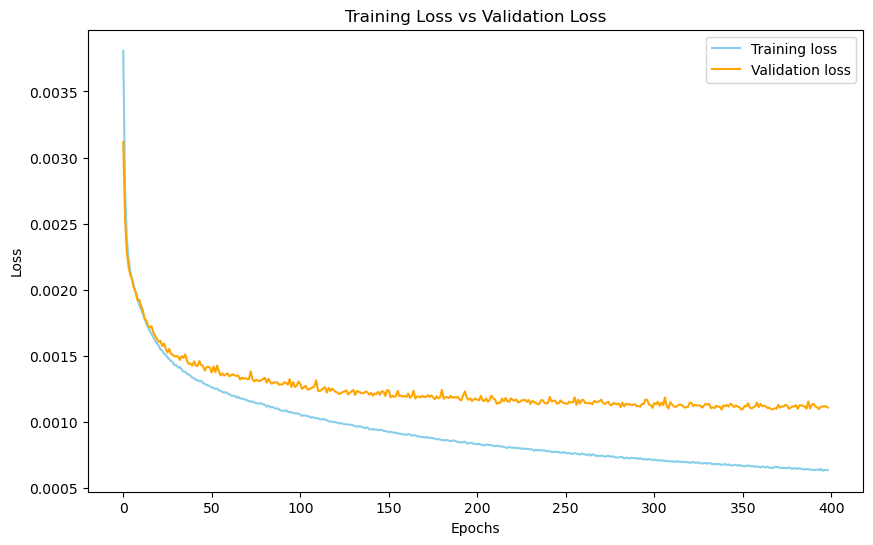

In [11]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(train_losses,label='Training loss',color='skyblue')
plt.plot(val_losses,label='Validation loss',color='orange')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss vs Validation Loss')
plt.legend()
plt.savefig('loss_plot')
plt.show()

In [8]:
!cd /kaggle/working

In [10]:
!zip -r zscore_fdnet_undersampled_alt_sources_Adamax.zip '/kaggle/working/zscore_fdnet_undersampled_alt_sources_Adamax'
from IPython.display import FileLink
FileLink('zscore_fdnet_undersampled_alt_sources_Adamax.zip')

  adding: kaggle/working/zscore_fdnet_undersampled_alt_sources_Adamax/ (stored 0%)
  adding: kaggle/working/zscore_fdnet_undersampled_alt_sources_Adamax/keras_metadata.pb (deflated 92%)
  adding: kaggle/working/zscore_fdnet_undersampled_alt_sources_Adamax/fingerprint.pb (stored 0%)
  adding: kaggle/working/zscore_fdnet_undersampled_alt_sources_Adamax/assets/ (stored 0%)
  adding: kaggle/working/zscore_fdnet_undersampled_alt_sources_Adamax/saved_model.pb (deflated 88%)
  adding: kaggle/working/zscore_fdnet_undersampled_alt_sources_Adamax/variables/ (stored 0%)
  adding: kaggle/working/zscore_fdnet_undersampled_alt_sources_Adamax/variables/variables.data-00000-of-00001 (deflated 9%)
  adding: kaggle/working/zscore_fdnet_undersampled_alt_sources_Adamax/variables/variables.index (deflated 66%)


/kaggle/working/zscore_fdnet_undersampled_alt_sources_Adamax.zip

In [23]:
'''
for file in os.listdir('/kaggle/input/test-disks-zscores-x/X/'):
    temp=np.load('/kaggle/input/test-disks-zscores-x/X/'+file)
    meas['amp']=temp[:576]
    meas['phase']=temp[576:]
    Allch_amp_phase=meas[(meas['grid_pos_1']%2!=0) & (meas['grid_pos_2']%2!=0)] 
    temp=pd.concat([Allch_amp_phase['amp'],Allch_amp_phase['phase']],ignore_index=True)
    temp=np.array(temp.values)
    np.save('/kaggle/working/alt_sources_test_disks/X/'+file,temp)
'''

In [3]:
import pickle
with open('/kaggle/input/zscores/factors.p', 'rb') as f:
    factor = pickle.load(f)
factors={}
factors['mean']=factor[0]
factors['std']=factor[1]
factors['mua_min']=factor[2]
factors['mua_range']=factor[3]
factors['mus_min']=factor[4]
factors['mus_range']=factor[5]
factors['dwn_factor']=factor[6]
factors['roi_factor']=factor[7]
factors

{'mean': array([ -9.76486598, -11.94126922, -13.68280513, ...,  22.52690221,
         36.74748799,  50.12313807]),
 'std': array([0.44787742, 0.63526332, 0.76196818, ..., 3.33164611, 5.36270396,
        7.41481909]),
 'mua_min': 0.004000351303254817,
 'mua_range': 0.031536837390914084,
 'mus_min': 0.5000241722787546,
 'mus_range': 2.492116532342978,
 'dwn_factor': [0.5, 0.5, 0.5],
 'roi_factor': 0.9066751953125}

In [4]:
loaded_model=tf.keras.models.load_model('/kaggle/input/fdnet-model/zscore_fdnet_undersampled_alt_sources_Adamax.h5')
final_model=keras.Model(loaded_model.input[0],loaded_model.output)

In [5]:
!pip install -U Kaleido

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 12.7 MB/s eta 0:00:0000:0100:01


In [6]:
import scipy.io, numpy as np,plotly.io as pio
from scipy.ndimage import zoom
from plotly.subplots import make_subplots
from skimage.metrics import structural_similarity as compare_ssim
import matplotlib.pyplot as plt

In [9]:
file_name='D10_1.npy'
depth=file_name.split('_')[0][1:]
temp=np.load('/kaggle/input/test-disks-zscores-x/alt_sources_test_disks/alt_sources_test_disks/X/'+file_name).reshape(1,-1)
y_pred=final_model.predict(temp)
y_pred_reshaped=np.squeeze(y_pred,0)
rescaled_y_pred_mua=(y_pred_reshaped[:,:,:,0]*factors['mua_range'])+factors['mua_min']
rescaled_y_pred_mus=(y_pred_reshaped[:,:,:,1]*factors['mus_range'])+factors['mus_min']

temp_dict=scipy.io.loadmat('/kaggle/input/test-disks/test_disks/'+file_name[:-4]+'.mat')
Y=zoom(temp_dict['target'],factors['dwn_factor']+[1],mode='reflect',order=1).astype('float32')
temp_y_mua=Y[:,:,:,0]
temp_y_mus=Y[:,:,:,1]

data_range_mua=np.max([np.max(rescaled_y_pred_mua),np.max(temp_y_mua)])-np.min([np.min(rescaled_y_pred_mua),np.min(temp_y_mua)])
ssim_value_mua = compare_ssim(rescaled_y_pred_mua, temp_y_mua, channel_axis=-1,data_range=data_range_mua)
data_range_mus=np.max([np.max(rescaled_y_pred_mus),np.max(temp_y_mus)])-np.min([np.min(rescaled_y_pred_mus),np.min(temp_y_mus)])
ssim_value_mus = compare_ssim(rescaled_y_pred_mus, temp_y_mus, channel_axis=-1,data_range=data_range_mus)

'mua'
''
legend_coord=[[0.4,0.78],[0.98,0.78],[0.4,0.2],[0.98,0.2]]
X, Y, Z = np.mgrid[:16, :16, :8]

fig1 = go.Figure(data=go.Volume(
    x=X.flatten(), y=Y.flatten(), z=Z.flatten(),
    value=rescaled_y_pred_mua.flatten(),
    isomin=np.min(np.min(rescaled_y_pred_mua))+(0*np.min(np.min(rescaled_y_pred_mua))),
    isomax=np.max(np.max(rescaled_y_pred_mua)),
    opacity=0.5,
    surface_count=6,
    colorbar=dict(len=0.4,x=legend_coord[0][0],y=legend_coord[0][1])
    ))
fig1.update_layout(scene_xaxis_showticklabels=False,
                  scene_yaxis_showticklabels=False,
                  scene_zaxis_showticklabels=False)
''
''
''
'Ground truth-mua'
''
X, Y, Z = np.mgrid[:16, :16, :8]

fig2 = go.Figure(data=go.Volume(
    x=X.flatten(), y=Y.flatten(), z=Z.flatten(),
    value=temp_y_mua.flatten(),
    isomin=np.min(np.min(temp_y_mua))+(0*np.min(np.min(temp_y_mua))),
    isomax=np.max(np.max(temp_y_mua)),
    opacity=0.5,
    surface_count=6,
    colorbar=dict(len=0.4,x=legend_coord[1][0],y=legend_coord[1][1])
    ))
fig2.update_layout(scene_xaxis_showticklabels=False,
                  scene_yaxis_showticklabels=False,
                  scene_zaxis_showticklabels=False)
''
''
''
'mus'
''
X, Y, Z = np.mgrid[:16, :16, :8]

fig3 = go.Figure(data=go.Volume(
    x=X.flatten(), y=Y.flatten(), z=Z.flatten(),
    value=rescaled_y_pred_mus.flatten(),
    isomin=np.min(np.min(rescaled_y_pred_mus))+(0*np.min(np.min(rescaled_y_pred_mus))),
    isomax=np.max(np.max(rescaled_y_pred_mus)),
    opacity=0.5,
    surface_count=6,
    colorbar=dict(len=0.4,x=legend_coord[2][0],y=legend_coord[2][1])
    ))
fig3.update_layout(scene_xaxis_showticklabels=False,
                  scene_yaxis_showticklabels=False,
                  scene_zaxis_showticklabels=False)
''
''
''
'Ground truth-mus'
''
X, Y, Z = np.mgrid[:16, :16, :8]

fig4 = go.Figure(data=go.Volume(
    x=X.flatten(), y=Y.flatten(), z=Z.flatten(),
    value=temp_y_mus.flatten(),
    isomin=np.min(np.min(temp_y_mus))+(0*np.min(np.min(temp_y_mus))),
    isomax=np.max(np.max(temp_y_mus)),
    opacity=0.5,
    surface_count=6,
    colorbar=dict(len=0.4,x=legend_coord[3][0],y=legend_coord[3][1])
    ))
fig4.update_layout(scene_xaxis_showticklabels=False,
                  scene_yaxis_showticklabels=False,
                  scene_zaxis_showticklabels=False)
''
''
''
fig = make_subplots(rows=2, cols=2, specs=[[{'type': 'scene'}, {'type': 'scene'}],[{'type': 'scene'},{'type': 'scene'}]])
for trace in fig1.data:
    fig.add_trace(trace, row=1, col=1)
for trace in fig2.data:
    fig.add_trace(trace, row=1, col=2)
for trace in fig3.data:
    fig.add_trace(trace, row=2, col=1)
for trace in fig4.data:
    fig.add_trace(trace, row=2, col=2)
fig.update_layout(title_text='Depth - '+depth+' mm',width=1000, height=800, annotations=[
        dict(text="Alternate source posistions-mua<br>SSIM: {:.6f}".format(ssim_value_mua), x=0.2, y=1, xref="paper", yref="paper", showarrow=False),
        dict(text="Ground truth-mua", x=0.8, y=1, xref="paper", yref="paper", showarrow=False),
        dict(text="Alternate source posistions-mus<br>SSIM: {:.6f}".format(ssim_value_mus), x=0.2, y=0.45, xref="paper", yref="paper", showarrow=False),
        dict(text="Ground truth-mus", x=0.8, y=0.45, xref="paper", yref="paper", showarrow=False)
    ])
pio.write_image(fig, "/kaggle/working/undersampled16_"+depth+".svg",format="svg")
pio.write_image(fig, "/kaggle/working/undersampled16_"+depth+".png",format="png")
fig.show()

1/1 [==============================] - 0s 53ms/step


In [13]:
import numpy as np
import scipy.ndimage as ndi
import numpy as np
import matplotlib.pyplot as plt

def get_lesion_centroids(volume, threshold=0.010):
    binary_mask = volume > threshold
    labeled, num_features = ndi.label(binary_mask)
    centroids = []
    for i in range(1, num_features + 1):
        lesion_data = labeled == i
        coords = np.argwhere(lesion_data)
        centroid = coords.mean(axis=0)
        centroids.append(centroid)
    return centroids
def extract_lesion_roi(volume, threshold):
    binary_mask = volume > threshold
    labeled, num_features = ndi.label(binary_mask)
    rois = []
    for i in range(1, num_features + 1):
        lesion_data = volume * (labeled == i)
        if np.any(lesion_data):
            rois.append(lesion_data)
    return rois

def compute_localization_error(predicted_centroid, ground_truth_centroid):
    return np.linalg.norm(np.array(predicted_centroid) - np.array(ground_truth_centroid))

def compute_effective_resolution(predicted_roi, ground_truth_centroid):
    coords = np.argwhere(predicted_roi)
    distances = [np.linalg.norm(coord - ground_truth_centroid) for coord in coords]
    max_distance = max(distances)
    # Diameter of the sphere
    return 2 * max_distance

# Example usage:

predicted_volume = rescaled_y_pred_mua  # Your predicted volume
ground_truth_volume = temp_y_mua  # Your ground truth volume

threshold = 0.00754  # adjust as per your requirement
predicted_centroids = get_lesion_centroids(predicted_volume, threshold)
ground_truth_centroids = get_lesion_centroids(ground_truth_volume, threshold)

predicted_rois = extract_lesion_roi(predicted_volume, threshold)
ground_truth_rois = extract_lesion_roi(ground_truth_volume, threshold)

localization_errors = []
effective_resolutions = []

for i, (predicted_roi, gt_roi) in enumerate(zip(predicted_rois, ground_truth_rois)):
    print(f"Processing lesion {i+1}...")

    # Compute localization error
    localization_error = compute_localization_error(predicted_centroids[i], ground_truth_centroids[i])
    print(f"Localization Error: {localization_error}")
    localization_errors.append(localization_error)

    # Compute effective resolution
    effective_res = compute_effective_resolution(predicted_roi, ground_truth_centroids[i])
    print(f"Effective Resolution: {effective_res}")
    effective_resolutions.append(effective_res)
    
lesions = list(range(1, len(localization_errors)+1))

Processing lesion 1...
Localization Error: 0.3218804428700388
Effective Resolution: 7.1221127340079615
Processing lesion 2...
Localization Error: 0.5954359623902662
Effective Resolution: 6.370431696517907


In [15]:
X, Y, Z = np.mgrid[:16, :16, :8]
fig2 = go.Figure(data=go.Volume(
    x=X.flatten(), y=Y.flatten(), z=Z.flatten(),
    value=predicted_rois[1].flatten(),
    isomin=np.min(np.min(predicted_rois[0]))+(0*np.min(np.min(predicted_rois[0]))),
    isomax=np.max(np.max(predicted_rois[0])),
    opacity=0.5,
    surface_count=6,
    colorbar=dict(len=0.4,x=legend_coord[1][0],y=legend_coord[1][1])
    ))
fig2.show()

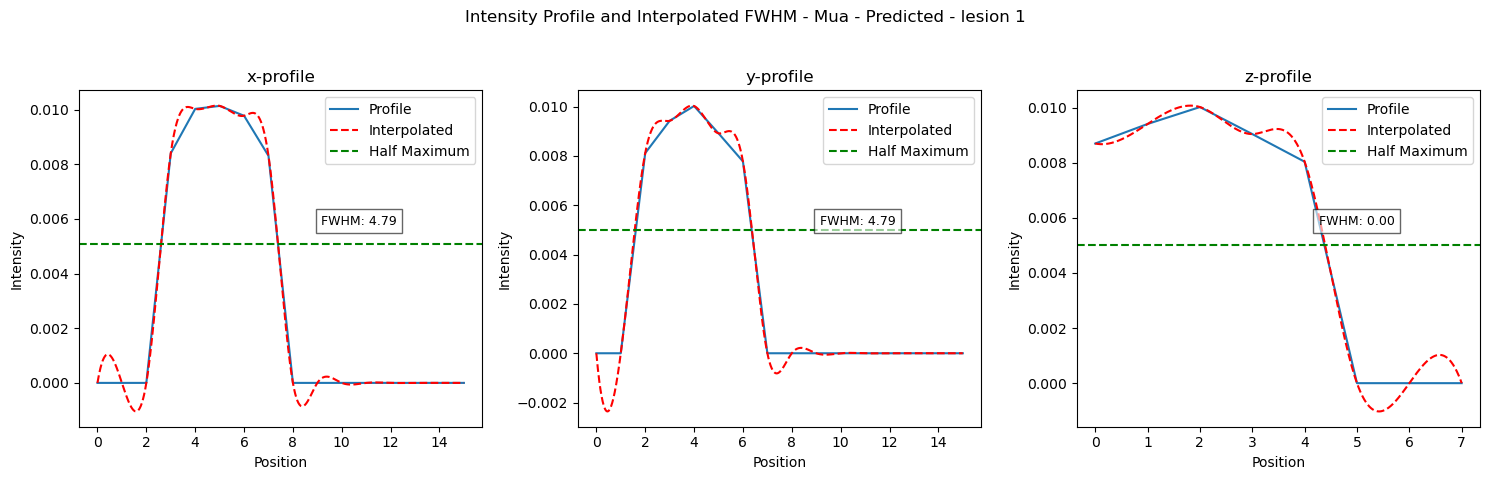

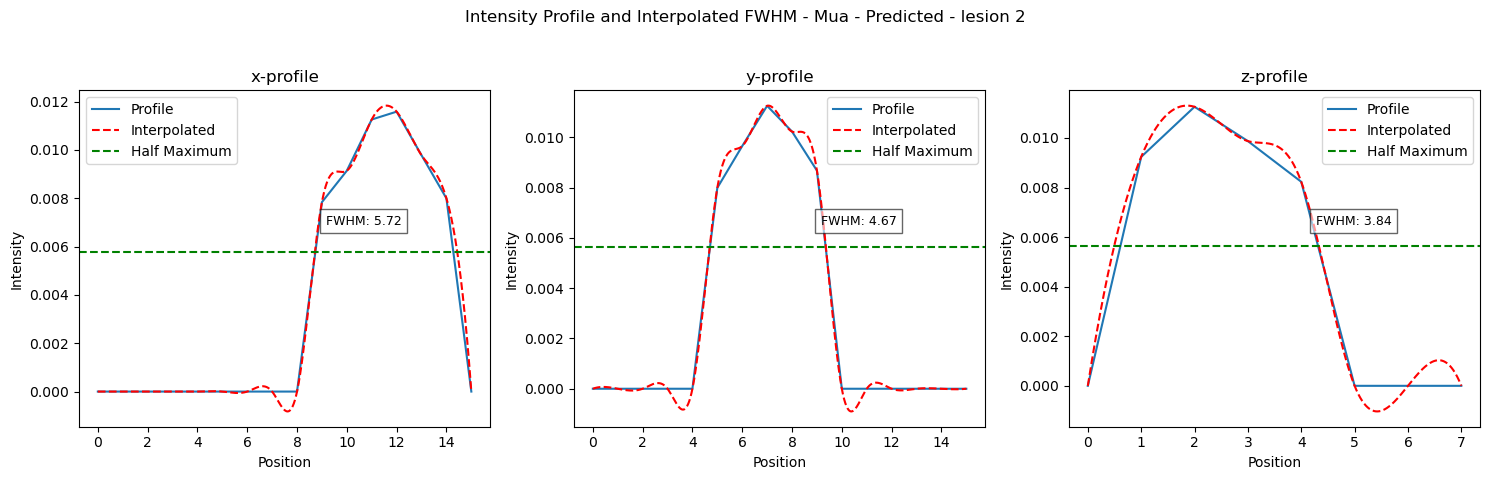

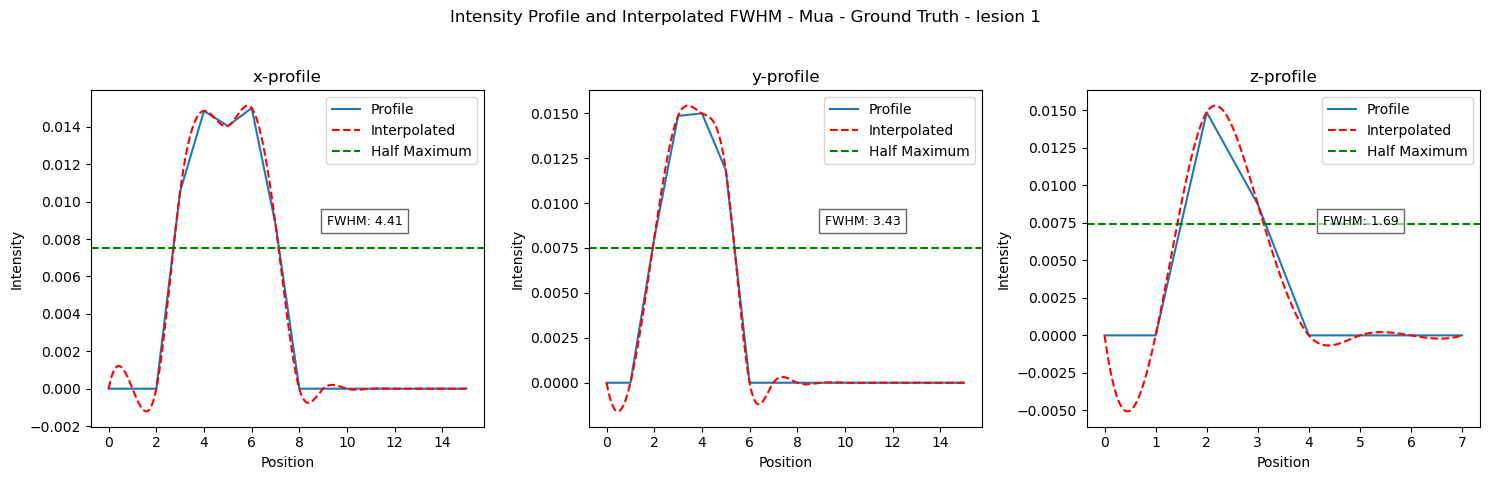

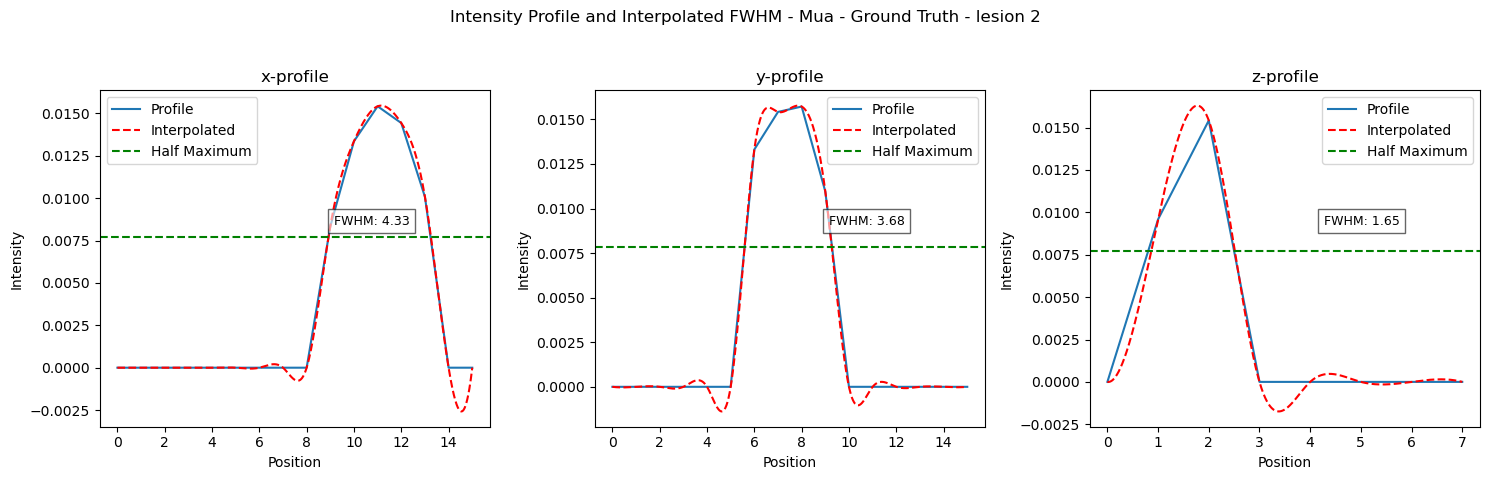

[[4.791726976856169, 4.7948567602036825, 0, 5.716567983190474, 4.6714325437130455, 3.839584547983608], [4.40926210906729, 3.4257049728672055, 1.6883040075058022, 4.329022065409742, 3.6805637160269296, 1.650185154402744]]


In [14]:
import numpy as np
import scipy.ndimage as ndi
from scipy.signal import find_peaks
from scipy.interpolate import UnivariateSpline
import matplotlib.pyplot as plt

def extract_lesion_roi(volume, threshold):
    binary_mask = volume > threshold
    labeled, num_features = ndi.label(binary_mask)
    rois = []
    for i in range(1, num_features + 1):
        lesion_data = volume * (labeled == i)
        if np.any(lesion_data):
            rois.append(lesion_data)
    return rois

def extract_profiles(roi):
    coords = np.argwhere(roi)
    centroid = coords.mean(axis=0).astype(int)
    profile_x = roi[:,centroid[1], centroid[2]]
    profile_y = roi[centroid[0], :, centroid[2]]
    profile_z= roi[centroid[0], centroid[1],:]
    return profile_x, profile_y, profile_z

def compute_fwhm(profile):
    half_max = np.max(profile) / 2.0
    spline = UnivariateSpline(range(len(profile)), profile - half_max, s=0)
    roots = spline.roots()
    if len(roots) >= 2:
        return abs(roots[-1] - roots[0])
    return 0

# Example usage:
volume1 = rescaled_y_pred_mua  # Replace with your volume
volume2 = temp_y_mua  # Replace with your volume

threshold = 0.00754  # Adjust based on your data

volumes = [volume1, volume2]
volume_name=['Predicted','Ground Truth']
roi_names=['lesion 1', 'lesion 2']
fwhms = []

for volume,vname in zip(volumes,volume_name):
    rois = extract_lesion_roi(volume, threshold)
    fwhm_values = []

    for roi,rname in zip(rois,roi_names):
        profiles = extract_profiles(roi)
        profile_names = ["x-profile", "y-profile", "z-profile"]
        
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))

        for idx, (profile, name) in enumerate(zip(profiles, profile_names)):
            if profile.ndim > 1:
                interpolated_profile = profile.sum(axis=1)
            else:
                interpolated_profile = profile
            fwhm = compute_fwhm(interpolated_profile)
            fwhm_values.append(fwhm)

            x = np.linspace(0, len(interpolated_profile)-1, 1000)
            spline = UnivariateSpline(range(len(interpolated_profile)), interpolated_profile - np.max(interpolated_profile) / 2.0, s=0)
            axes[idx].plot(interpolated_profile, label='Profile')
            axes[idx].plot(x, spline(x) + np.max(interpolated_profile) / 2.0, 'r--', label='Interpolated')
            axes[idx].axhline(y=np.max(interpolated_profile)/2.0, color='g', linestyle='--', label='Half Maximum')
            axes[idx].text(0.6, 0.6, f'FWHM: {fwhm:.2f}', transform=axes[idx].transAxes, fontsize=9, bbox=dict(facecolor='white', alpha=0.6))  # Display FWHM on the graph
            axes[idx].set_title(name)
            axes[idx].set_xlabel("Position")
            axes[idx].set_ylabel("Intensity")
            legend = axes[idx].legend()
            
        
        fig.suptitle("Intensity Profile and Interpolated FWHM - "+"Mua - " + vname+" - "+rname)
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.savefig("amp_mua_288_16_"+f"{vname}_{rname}.png")
        plt.show()
        plt.close(fig)


    fwhms.append(fwhm_values)

print(fwhms)


In [16]:
#mus-LOCA & ER
import numpy as np
import scipy.ndimage as ndi
import numpy as np
import matplotlib.pyplot as plt

def get_lesion_centroids(volume, threshold=0.010):
    binary_mask = volume > threshold
    labeled, num_features = ndi.label(binary_mask)
    centroids = []
    for i in range(1, num_features + 1):
        lesion_data = labeled == i
        coords = np.argwhere(lesion_data)
        centroid = coords.mean(axis=0)
        centroids.append(centroid)
    return centroids

def compute_localization_error(predicted_centroid, ground_truth_centroid):
    return np.linalg.norm(np.array(predicted_centroid) - np.array(ground_truth_centroid))

def compute_effective_resolution(predicted_roi, ground_truth_centroid):
    coords = np.argwhere(predicted_roi)
    distances = [np.linalg.norm(coord - ground_truth_centroid) for coord in coords]
    max_distance = max(distances)
    # Diameter of the sphere
    return 2 * max_distance

# Example usage:

predicted_volume = rescaled_y_pred_mus  # Your predicted volume
ground_truth_volume = temp_y_mus  # Your ground truth volume

threshold = 0.8  # adjust as per your requirement
predicted_centroids = get_lesion_centroids(predicted_volume, threshold)
ground_truth_centroids = get_lesion_centroids(ground_truth_volume, threshold)

predicted_rois = extract_lesion_roi(predicted_volume, threshold)
ground_truth_rois = extract_lesion_roi(ground_truth_volume, threshold)

localization_errors = []
effective_resolutions = []

for i, (predicted_roi, gt_roi) in enumerate(zip(predicted_rois, ground_truth_rois)):
    print(f"Processing lesion {i+1}...")

    # Compute localization error
    localization_error = compute_localization_error(predicted_centroids[i], ground_truth_centroids[i])
    print(f"Localization Error: {localization_error}")
    localization_errors.append(localization_error)

    # Compute effective resolution
    effective_res = compute_effective_resolution(predicted_roi, ground_truth_centroids[i])
    print(f"Effective Resolution: {effective_res}")
    effective_resolutions.append(effective_res)
    
lesions = list(range(1, len(localization_errors)+1))


Processing lesion 1...
Localization Error: 8.606047812841624
Effective Resolution: 18.404684900966245
Processing lesion 2...
Localization Error: 5.739891864230482
Effective Resolution: 28.064009218335062


In [17]:
X, Y, Z = np.mgrid[:16, :16, :8]
fig2 = go.Figure(data=go.Volume(
    x=X.flatten(), y=Y.flatten(), z=Z.flatten(),
    value=predicted_rois[1].flatten(),
    isomin=np.min(np.min(predicted_rois[0]))+(0*np.min(np.min(predicted_rois[0]))),
    isomax=np.max(np.max(predicted_rois[0])),
    opacity=0.5,
    surface_count=6,
    colorbar=dict(len=0.4,x=legend_coord[1][0],y=legend_coord[1][1])
    ))
fig2.show()

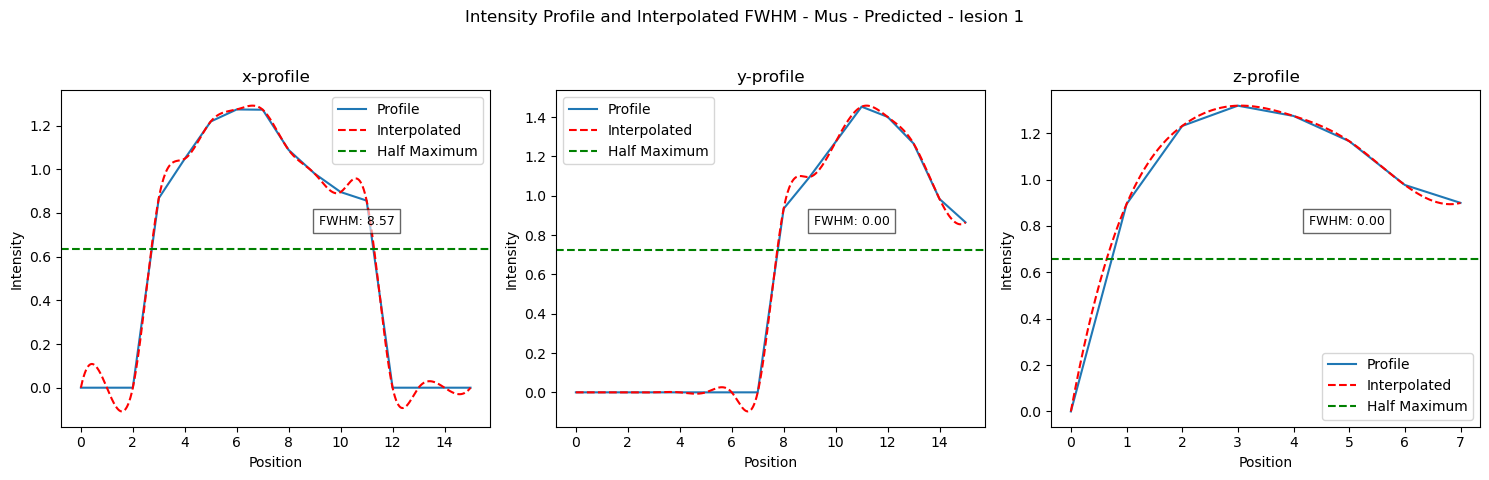

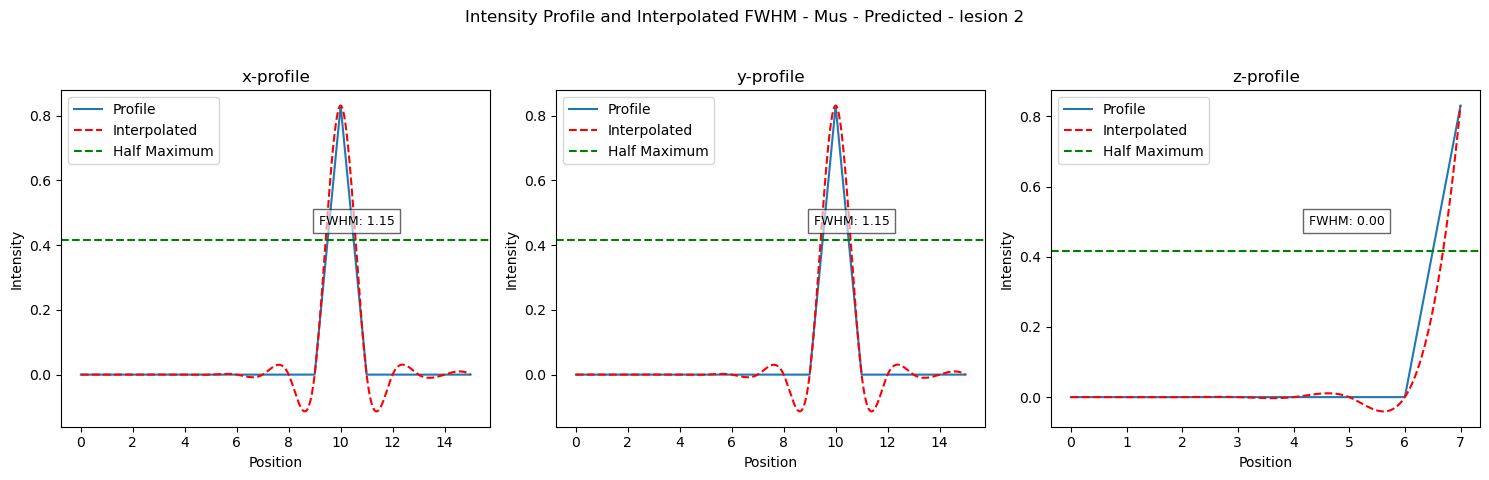

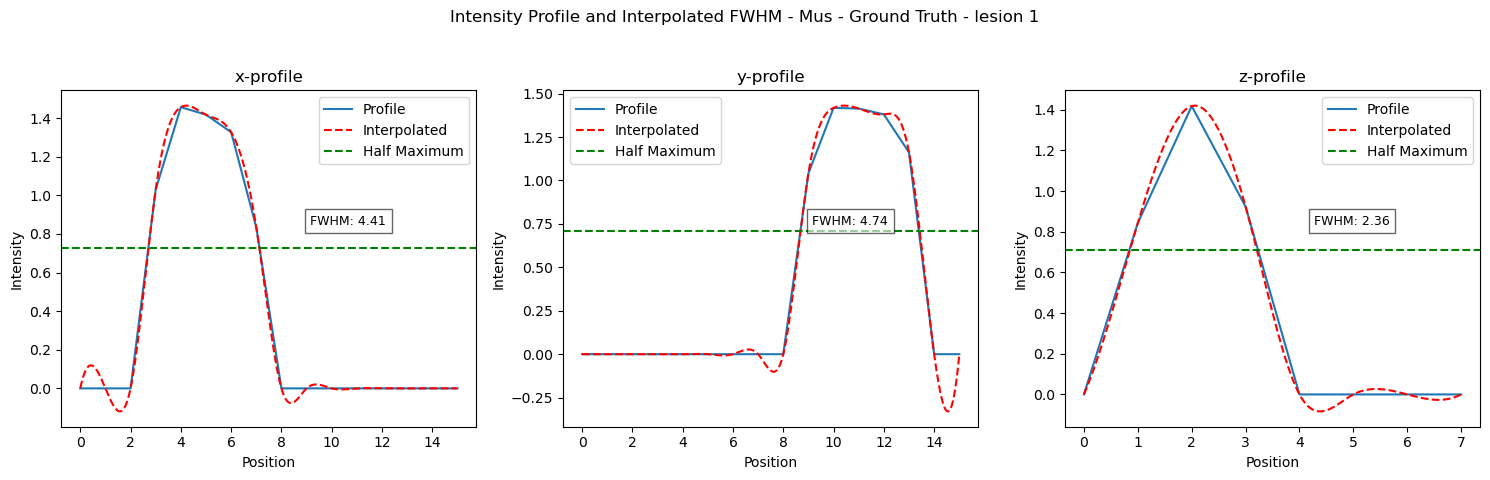

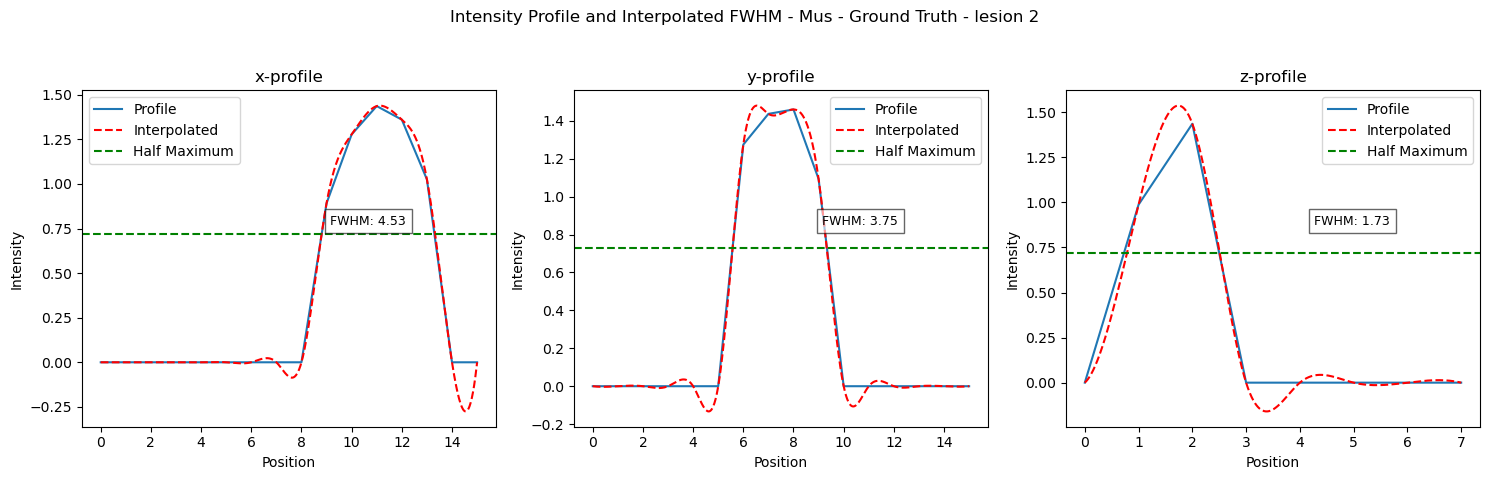

[[8.57222477905097, 0, 0, 1.1519657219431902, 1.1519657219431902, 0], [4.40667001156089, 4.738599170618102, 2.35840800120001, 4.5254028430280115, 3.7509010946085066, 1.7254063332174718]]


In [17]:
import numpy as np
import scipy.ndimage as ndi
from scipy.signal import find_peaks
from scipy.interpolate import UnivariateSpline
import matplotlib.pyplot as plt

def extract_lesion_roi(volume, threshold):
    binary_mask = volume > threshold
    labeled, num_features = ndi.label(binary_mask)
    rois = []
    for i in range(1, num_features + 1):
        lesion_data = volume * (labeled == i)
        if np.any(lesion_data):
            rois.append(lesion_data)
    return rois

def extract_profiles(roi):
    coords = np.argwhere(roi)
    centroid = coords.mean(axis=0).astype(int)
    profile_x = roi[:,centroid[1], centroid[2]]
    profile_y = roi[centroid[0], :, centroid[2]]
    profile_z= roi[centroid[0], centroid[1],:]
    return profile_x, profile_y, profile_z

def compute_fwhm(profile):
    half_max = np.max(profile) / 2.0
    spline = UnivariateSpline(range(len(profile)), profile - half_max, s=0)
    roots = spline.roots()
    if len(roots) >= 2:
        return abs(roots[-1] - roots[0])
    return 0

# Example usage:
volume1 = rescaled_y_pred_mus  # Replace with your volume
volume2 = temp_y_mus  # Replace with your volume

threshold = 0.83  # Adjust based on your data

volumes = [volume1, volume2]
volume_name=['Predicted','Ground Truth']
roi_names=['lesion 1', 'lesion 2']
fwhms = []

for volume,vname in zip(volumes,volume_name):
    rois = extract_lesion_roi(volume, threshold)
    fwhm_values = []

    for roi,rname in zip(rois,roi_names):
        profiles = extract_profiles(roi)
        profile_names = ["x-profile", "y-profile", "z-profile"]
        
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))

        for idx, (profile, name) in enumerate(zip(profiles, profile_names)):
            if profile.ndim > 1:
                interpolated_profile = profile.sum(axis=1)
            else:
                interpolated_profile = profile
            fwhm = compute_fwhm(interpolated_profile)
            fwhm_values.append(fwhm)

            x = np.linspace(0, len(interpolated_profile)-1, 1000)
            spline = UnivariateSpline(range(len(interpolated_profile)), interpolated_profile - np.max(interpolated_profile) / 2.0, s=0)
            axes[idx].plot(interpolated_profile, label='Profile')
            axes[idx].plot(x, spline(x) + np.max(interpolated_profile) / 2.0, 'r--', label='Interpolated')
            axes[idx].axhline(y=np.max(interpolated_profile)/2.0, color='g', linestyle='--', label='Half Maximum')
            axes[idx].text(0.6, 0.6, f'FWHM: {fwhm:.2f}', transform=axes[idx].transAxes, fontsize=9, bbox=dict(facecolor='white', alpha=0.6))  # Display FWHM on the graph
            axes[idx].set_title(name)
            axes[idx].set_xlabel("Position")
            axes[idx].set_ylabel("Intensity")
            legend = axes[idx].legend()
            
        
        fig.suptitle("Intensity Profile and Interpolated FWHM - "+"Mus - " + vname+" - "+rname)
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.savefig("amp_mus_288_16_"+f"{vname}_{rname}.png")
        plt.show()
        plt.close(fig)

    fwhms.append(fwhm_values)

print(fwhms)
